In [1]:
# Import packages

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys

import torch
from torch import nn
from torch.nn import  Embedding, LSTM, Linear, Softmax, Module, CrossEntropyLoss
import torch.nn.functional as F
from torch import optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [2]:
# Import data

pfam_dir = '../data/random_split'

# Load data

def load_data(folder):
    data = []
    for file in os.listdir(folder):
        file_data = pd.read_csv(os.path.join(folder, file), index_col=None)
        data.append(file_data.reset_index(drop=True))
    return pd.concat(data, ignore_index=True)


In [3]:
train = load_data(os.path.join(pfam_dir, 'train'))
dev = load_data(os.path.join(pfam_dir, 'dev'))
test = load_data(os.path.join(pfam_dir, 'test'))

In [23]:
train.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...
1,DUF2887,K9QI92_9NOSO/3-203,PF11103.8,RDSIYYQIFKRFPALIFEL..VD.NRPPQAQNYRFESVEVKETAFR...,RDSIYYQIFKRFPALIFELVDNRPPQAQNYRFESVEVKETAFRIDG...
2,zf-IS66,Q92LC9_RHIME/32-75,PF13005.7,.TCCPDCGG.E..LRLVGED.AS....EILDMI.AAQMKVIEVARL...,TCCPDCGGELRLVGEDASEILDMIAAQMKVIEVARLKKSCRCCE
3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...
4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...


In [22]:
train['family_id'][0]

'GMC_oxred_C'

In [24]:
# print the shape of the data
print("Train shape : ", train.shape)
print("Dev shape : ", dev.shape)
print("Test shape : ", test.shape)

Train shape :  (1086741, 5)
Dev shape :  (126171, 5)
Test shape :  (126171, 5)


# 1. Data analysis and visualisation

In [4]:
# Create a partition of the data

partition = { 'train': train, 'dev': dev, 'test': test }

In [5]:
# Get the sequence length for each sequence in the dataset

def get_sequence_length(data):

    data['seq_length'] = data['sequence'].apply(lambda x: len(x))
    return data

for key in partition.keys():
    partition[key] = get_sequence_length(partition[key])

In [27]:
# Generate a table of the information for each dataset in the partition, including data size, relative ratio (vs total data), number of unique families, 
# average number of sequences per family, maximum number of sequences per family, average sequence length, maximum sequence length and missing values.

def data_info(partition):
    total_data = pd.concat(partition.values())
    data_info = {}
    for key in partition.keys():
        data = partition[key]
        data_info[key] = {
            'data_size': data.shape[0],
            'relative_ratio': data.shape[0] / total_data.shape[0],
            'unique_families': len(data['family_accession'].unique()),
            'avg_seq_per_family': data.shape[0] / len(data['family_accession'].unique()),
            'max_seq_per_family': data['family_accession'].value_counts().max(),
            'avg_seq_length': data['seq_length'].mean(),
            'max_seq_length': data['seq_length'].max(),
            'missing_values': data.isnull().sum().sum()
        }

    # save the table as a csv file
    pd.DataFrame(data_info).T.to_csv('../analysis/data_info.csv')

    return pd.DataFrame(data_info).T

data_info(partition)

,data_size,relative_ratio,unique_families,avg_seq_per_family,max_seq_per_family,avg_seq_length,max_seq_length,missing_values
train,1086741.0,0.811556,17929.0,60.613587,3637.0,155.379971,2037.0,0.0
dev,126171.0,0.094222,13071.0,9.652743,454.0,154.222206,1971.0,0.0
test,126171.0,0.094222,13071.0,9.652743,454.0,154.166845,1937.0,0.0


In [6]:
# Get the families with the most sequences, top 50

top_50_prot_families = train['family_accession'].value_counts().head(50)

# Get new dataframes with only the top 50 protein families

train_top_50 = train[train['family_accession'].isin(top_50_prot_families.index)]
dev_top_50 = dev[dev['family_accession'].isin(top_50_prot_families.index)]
test_top_50 = test[test['family_accession'].isin(top_50_prot_families.index)]



In [7]:
print("Train shape : ", train_top_50.shape)
print("Dev shape : ", dev_top_50.shape)
print("Test shape : ", test_top_50.shape)

Train shape :  (55216, 6)
Dev shape :  (6875, 6)
Test shape :  (6875, 6)


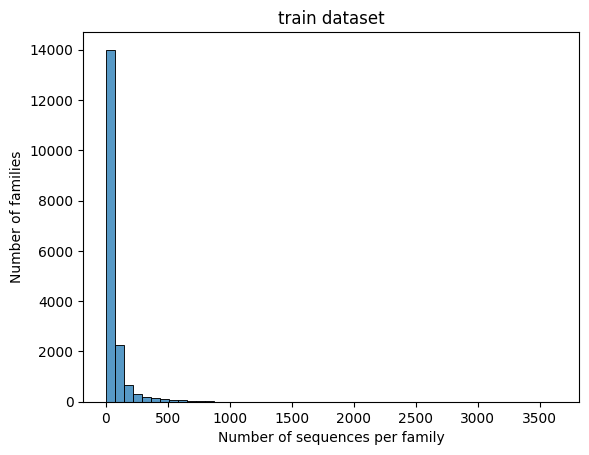

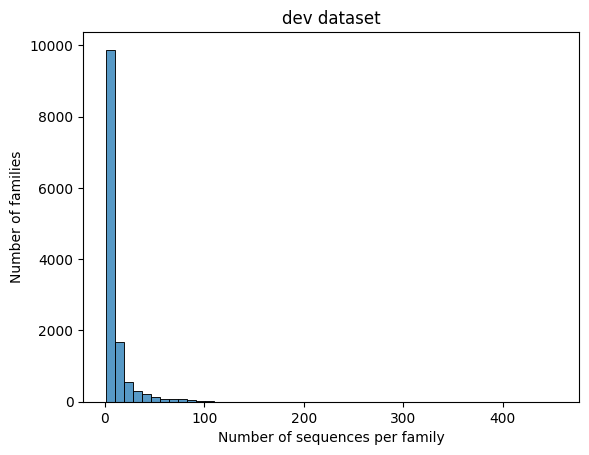

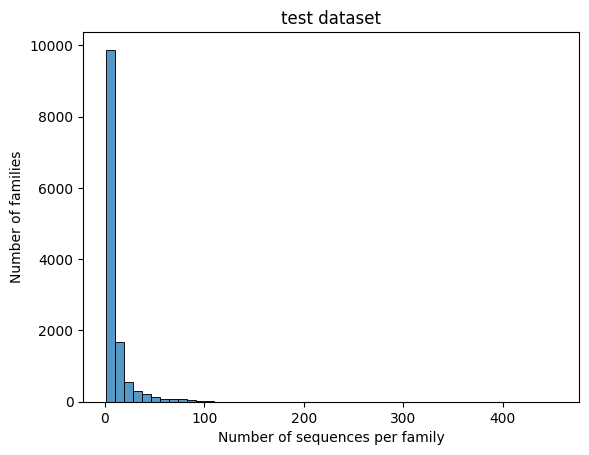

In [20]:
# Visualize the distribution of the number of sequences per family, for each dataset in the partition

def plot_seq_per_family(partition):
    for key in partition.keys():
        data = partition[key]
        sns.histplot(data['family_accession'].value_counts(), bins=50)
        plt.title(f'{key} dataset')
        plt.xlabel('Number of sequences per family')
        plt.ylabel('Number of families')
        plt.show()

plot_seq_per_family(partition)

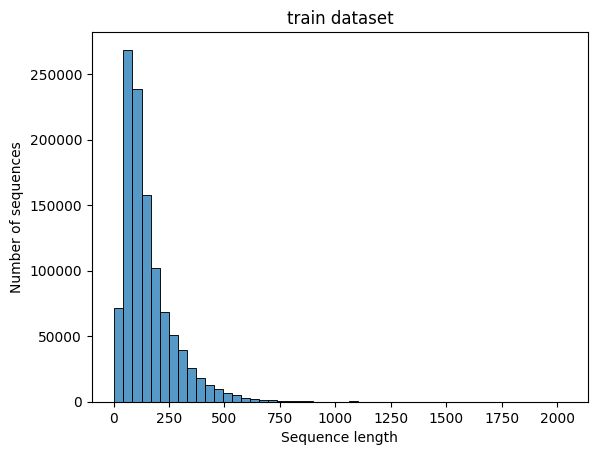

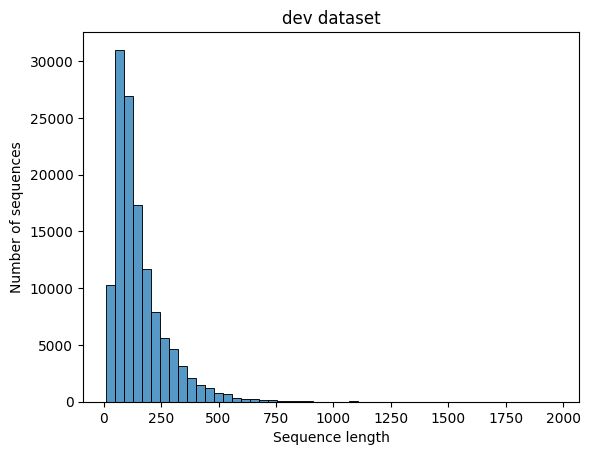

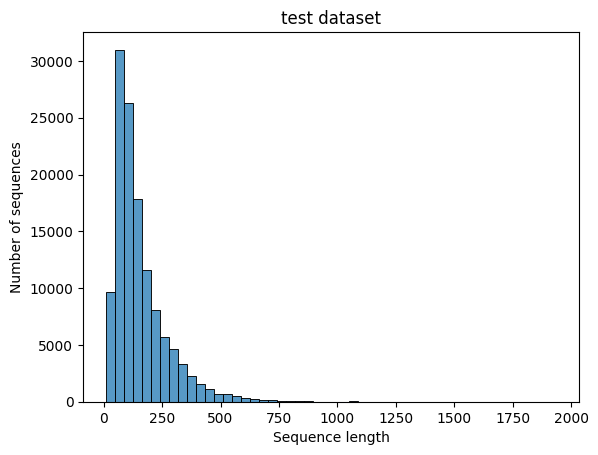

In [25]:
# Visualize the distribution of sequence lengths, for each dataset in the partition

def plot_seq_length(partition):
    for key in partition.keys():
        data = partition[key]
        sns.histplot(data['seq_length'], bins=50)
        plt.title(f'{key} dataset')
        plt.xlabel('Sequence length')
        plt.ylabel('Number of sequences')
        plt.show()

plot_seq_length(partition)

### Class imbalance noted for number of sequence per family distribution and the number of residues per sequence

In [10]:
# Compute the sequence length distribution and the maximum sequence length covering 80% of sequences

coverage_threshold = 0.80

def sequence_length_distribution(data, coverage_threshold):
    seq_lengths = data['seq_length'].value_counts().sort_index()
    seq_lengths = seq_lengths.cumsum() / seq_lengths.sum()
    max_seq_length = seq_lengths[seq_lengths < coverage_threshold].index.max()
    return seq_lengths, max_seq_length

seq_lengths, max_seq_length = sequence_length_distribution(train, coverage_threshold)


print(f"Maximum sequence length covering {coverage_threshold * 100}% of sequences: {max_seq_length}")

Maximum sequence length covering 80.0% of sequences: 222


KeyboardInterrupt: 

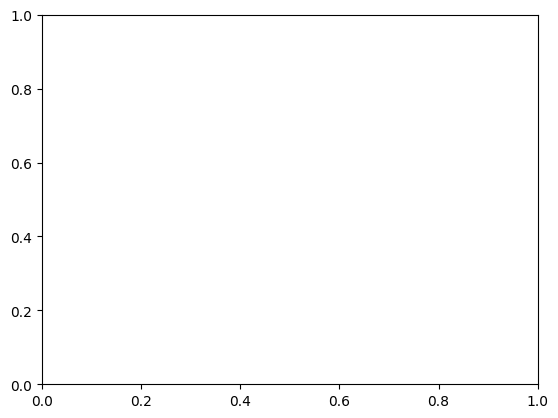

In [26]:
# Visualize the distribution of amino acids in the sequences, for each dataset in the partition

def plot_amino_acids(partition):
    for key in partition.keys():
        data = partition[key]
        amino_acids = pd.Series(list(''.join(data['sequence'])))
        sns.countplot(amino_acids)
        plt.title(f'{key} dataset')
        plt.xlabel('Amino acid')
        plt.ylabel('Number of occurrences')
        plt.show()

plot_amino_acids(partition)

# 2. Protein Sequence Encoding

In [11]:
# Encode the amino acids in the sequences

# Create a dictionary to map each amino acid to an integer

amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
rare_amino_acids = 'BJOUXZ'
aa_dict = {aa: i + 1 for i, aa in enumerate(amino_acids)}
for i, aa in enumerate(rare_amino_acids):
    aa_dict[aa] = 0


In [44]:
len(aa_dict)

26

In [12]:
# Use integer encoding to encode the amino acids in the sequences, adding padding to max length

def encode_sequence(partition):
    encoded_sequences = []
    for seq in partition['sequence']:
        sequence_encoded = [aa_dict.get(aa, len(aa_dict)) for aa in seq[:max_seq_length]]
        sequence_encoded += [0] * (max_seq_length - len(sequence_encoded))
        encoded_sequences.append(sequence_encoded)
    return encoded_sequences

for key in partition.keys():
    partition[key]['encoded_sequence'] = encode_sequence(partition[key])

In [32]:
train.head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence,seq_length,encoded_sequence
0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...,124,"[13, 7, 13, 4, 16, 15, 8, 15, 10, 16, 17, 15, ..."
1,DUF2887,K9QI92_9NOSO/3-203,PF11103.8,RDSIYYQIFKRFPALIFEL..VD.NRPPQAQNYRFESVEVKETAFR...,RDSIYYQIFKRFPALIFELVDNRPPQAQNYRFESVEVKETAFRIDG...,201,"[15, 3, 16, 8, 20, 20, 14, 8, 5, 9, 15, 5, 13,..."
2,zf-IS66,Q92LC9_RHIME/32-75,PF13005.7,.TCCPDCGG.E..LRLVGED.AS....EILDMI.AAQMKVIEVARL...,TCCPDCGGELRLVGEDASEILDMIAAQMKVIEVARLKKSCRCCE,44,"[17, 2, 2, 13, 3, 2, 6, 6, 4, 10, 15, 10, 18, ..."
3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,115,"[11, 10, 15, 11, 11, 11, 12, 16, 9, 8, 7, 15, ..."
4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...,98,"[17, 1, 2, 13, 9, 14, 2, 17, 1, 15, 6, 10, 6, ..."


In [14]:
# convert the encoded sequences to tensors

for key in partition.keys():
    partition[key]['sequence_tensor'] = partition[key]['encoded_sequence'].apply(lambda x: torch.tensor(x))



In [37]:
# print the shape of the encoded sequences

print("Train shape : ", partition['train']['sequence_tensor'].shape)
print("Dev shape : ", partition['dev']['sequence_tensor'].shape)
print("Test shape : ", partition['test']['sequence_tensor'].shape)

Train shape :  (1086741,)
Dev shape :  (126171,)
Test shape :  (126171,)


In [15]:
x_train = pad_sequence(partition['train']['sequence_tensor'], batch_first=True).float()
x_dev = pad_sequence(partition['dev']['sequence_tensor'], batch_first=True).float()
x_test = pad_sequence(partition['test']['sequence_tensor'], batch_first=True).float()

In [16]:
x_train.shape

torch.Size([1086741, 222])

In [66]:
x_train.dtype

torch.float32

In [17]:
# Encode the family accession labels

label_encoder = LabelEncoder()

labels_train = label_encoder.fit_transform(partition['train']['family_accession'])
labels_dev = label_encoder.transform(partition['dev']['family_accession'])
labels_test = label_encoder.transform(partition['test']['family_accession'])


# 3. Model Training

In [18]:
# Create PyTorch datasets and dataloaders, as float32 tensors

batch_size = 64

train_dataset = TensorDataset(x_train, torch.tensor(labels_train))
dev_dataset = TensorDataset(x_dev, torch.tensor(labels_dev))
test_dataset = TensorDataset(x_test, torch.tensor(labels_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
# check data type of the train_dataset x and y tensors, whether they are float or integer

print(train_dataset.tensors[0].dtype)
print(train_dataset.tensors[1].dtype)

torch.float32
torch.int64


In [19]:
# Define a simple neural network
class SimpleNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [20]:
x_train.shape[1]

222

In [21]:
# Hyperparameters
input_dim = x_train.shape[1]
hidden_dim = 128
output_dim = len(set(labels_train))

model = SimpleNN(input_dim, hidden_dim, output_dim)
# Check if CUDA (GPU) is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training function
def train_model(model, train_loader, dev_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.view(inputs.size(0), -1)  # Flatten the inputs
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader)}')

        # Evaluate on development set
        model.eval()
        dev_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in dev_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs.view(inputs.size(0), -1)  # Flatten the inputs
                outputs = model(inputs)
                
                loss = criterion(outputs, labels)
                dev_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        dev_loss /= len(dev_loader)
        accuracy = 100 * correct / total
        print(f'Dev Loss: {dev_loss:.4f}, Dev Accuracy: {accuracy:.2f}%')

# Train the model
train_model(model, train_loader, dev_loader, criterion, optimizer)

Epoch 1/10, Loss: 6.774184949616648
Dev Loss: 6.1519, Dev Accuracy: 9.54%
Epoch 2/10, Loss: 6.246214234487067
Dev Loss: 6.0075, Dev Accuracy: 10.40%


KeyboardInterrupt: 

In [24]:
# Design a simple three-layer CNN model

class FullyConnected(torch.nn.Module):
    """Fully connected NN model."""
    def __init__(self, input_dim, output_dim):
        """
        Args:
        input_dim  (int): input vector size.
        output_dim (int): output vector size (number of classes).
        """
        super(FullyConnected, self).__init__()
        self.linear1 = torch.nn.Linear(input_dim, input_dim)
        self.linear2 = torch.nn.Linear(input_dim, input_dim)
        self.linear3 = torch.nn.Linear(input_dim, output_dim)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.1)

    def forward(self, x):
        x = self.dropout(self.relu(self.linear1(x)))
        x = self.dropout(self.relu(self.linear2(x)))
        x = self.dropout(self.relu(self.linear3(x)))
        y = torch.nn.functional.softmax(x, dim=-1)
        return y

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device is : ', device)

model1 = FullyConnected(x_train.shape[1], 100).to(device)
loss_function = torch.nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(model1.parameters())

Device is :  cuda


In [26]:



def train_evaluate(model, optimizer, loss_function, train_dataloader, val_dataloader, epochs=10, device='cpu'):
    logs = {} 
    logs['loss'] = []
    logs['acc'] = []
    logs['val_loss'] = []
    logs['val_acc'] = []

    for epoch in range(1, epochs+1):
        # --- TRAIN AND EVALUATE ON TRAINING SET 
        model.train()

        train_loss = 0.0
        num_train_correct = 0
        num_train_examples = 0

        for x, y in train_dataloader:
            optimizer.zero_grad()

            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = loss_function(y_pred, y)

            loss.backward()
            optimizer.step()

            train_loss += loss.data.item() 
            num_train_correct += (torch.max(y_pred, 0)[0] == y).sum().item()
            num_train_examples += x.shape[0]

        train_acc = num_train_correct / num_train_examples
        train_loss = train_loss / len(train_dataloader.dataset)


        # --- EVALUATE ON VALIDATION SET -------------------------------------
        model.eval()
        val_loss = 0.0
        num_val_correct = 0
        num_val_examples = 0

        for x, y in val_dataloader:
            x = x.to(device)
            y = y.to(device)
            y_pred = model(x)
            loss = loss_function(y_pred, y)

            val_loss += loss.data.item()
            num_val_correct += (torch.max(y_pred, 0)[0] == y).sum().item()
            num_val_examples += y.shape[0]

        val_acc = num_val_correct / num_val_examples
        val_loss = val_loss / len(val_dataloader.dataset)

        if epoch == 1 or epoch % 10 == 0:
          print('Epoch %3d/%3d, train loss: %5.2f, train acc: %5.2f, val loss: %5.2f, val acc: %5.2f' % \
                (epoch, epochs, train_loss, train_acc, val_loss, val_acc))

        logs['loss'].append(train_loss)
        logs['acc'].append(train_acc)
        logs['val_loss'].append(val_loss)
        logs['val_acc'].append(val_acc)

    return logs

In [27]:
logs = train_evaluate(
    model = model1,
    optimizer = optimizer1,
    loss_function = loss_function,
    train_dataloader = train_loader,
    val_dataloader = dev_loader,
    epochs=25,
    device=device)

../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [0,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [1,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [2,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [3,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [4,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_forward_reduce_cuda_kernel_2d: block: [0,0,0], thread: [5,0,0] Assertion `t >= 0 && t < n_classes` failed.
../aten/src/ATen/native/cuda/Loss.cu:250: nll_loss_f

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
